# Feature selection algorithm description:
### In this short segment we describe how the feature selection we performed.
Lets assume that we have some signal $\mathcal{S}$ that is recored at $N$ time points. Alongside the signal we have a set of  $m$ variables $$\{c_i | i  = 1...m\}$$, whose values are also recorded at $N$ time points. These variables might correlate nicely with the signal or more interestingly their (nonlinear) combinations might be responsibe for the signal shape. Our goal is to identify which among these combinations influence the singal the most.
<br>
<br>
To acheive that we first construct some nonlinear features, the Occams rasor of nonlinear features are naturally the quadratic, however, combinations of higher order might sometimes be necessary. Here we constructed a set of features 
$$\mathcal{P} = \{ c_i c_j | i,j = 0,1...m \} = \{p_k | k = 1,...M\}$$
 Let the number of polynomial feature be $M$. Notice that the i and j indices start at 0, by definition we assume $c_i = 1$, in this way we can compactly lump together the linear and polynomial features.

### The signal and features are scaled to zero mean and unitary variance.

After the appropriate feature normalization, we construct a simple linear model $\mathcal{L}:\mathbb{R}^M\rightarrow \mathbb{R}$ as 
$$
F(\textbf{p(t)}) = \sum _k^M w_k p_k
$$
Where $\textbf{p(t)}$ is a vector consisting of polynomial features $p_k$ at time $t$. The model produces outputs for all $N$ time instants. The goal here is to find the weight vector $\textbf{w}$ such that the model correlates wiht the signal $\mathcal{S}$ as much as possible.

### Optimization procedure

Now that the model has been defined we need an appropriate heuristic that should help us find the weights. As was previously mentioned we intend for the model to correlate with the signal as much as possible. A naive approach could be to simple use the pearson correlation coefficient as a metric:
$$
L = 1 -\frac{
    \mathbb{E}\bigl( (F - \mu_F)(\mathcal{S}-\mu_{\mathcal{S}}) \bigr)}
    {\sigma_{F}\sigma_{\mathcal{S}}}
$$
The expectaions and standard deviations should be calculated over the time interval or subintervals. However, this proved to be troublesome when one of the variables remains constant throughout the subinterval. A more convenient loss might be the (negative) cosine similarity that calculates the same quantity without the variables being shifted by the mean.
$$
L_{cos} = 1 - \frac{ \sum_i^N(F_i \mathcal{S_i})}
               {||F||\cdot ||\mathcal{S}||}
$$
The sum in the numerator and the norms in the denominator are calculated over the entire time interval. The minus signs in $L$ and $L_{cos}$ are inserted because the optimization alogrithm minimizes losses.
<br>
While this might give us a model that correlates with the singal strongly, we would also like the model to be sparse i.e. we want only a small number of weight to have a large value. Plainly said we want the model to use only a small number of most important features to correlate with the signal. To add that requirement we add a regularization loss to the cosine loss.
The complete loss function becomes:
$$
L = L_{cos} + L_{reg}
$$
Where $L_{reg}$ is $$L_{reg} = \lambda \sum_i^M|w_i|$$ This is the so-called L1 norm of the weights, and the paramter $\lambda$ dictates the level of importance we place on regularization, in our experiments the best results were obtained for $\lambda = 1$.

### Feature selection
If the model was trained appropriately the features with the largest weights should be the most important ones. However, the weights were initalized randomly, so in order to obtain some reproucibility and a better estimate to the selected features we did the following:
<br>
We introduced another vector apptly named frature scores, or $S_c$. We trained the model $E$ number of times and for every time we would update the scores:
$$
S_c \leftarrow S_c + \frac{\textbf{w}}{||\textbf{w}||\cdot L}
$$
This way we prefer the variables with higher weights as well as training iterations with lower loss. After the last iteration the score vector $S_c$ should give a ranking of most important variables, and the top $n$ can be used as relevant features.


$$w_k \in \mathbb{R} \; \forall k = 1,...M$$

In [1]:
from data_augmentator import Data_Augmentator
from BKG_Dataholder import BKG_dataholder
from Coll_Data_Aug import Coll_Data_Augmentator


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import os
import json
import time,datetime
import tables as t
from tqdm import tqdm

%matplotlib inline

# Collimator Feature selection
### We assume that the the collimator positions affect the beam induced background in some nonlinear manner. This is achieved by creating polyinomial interaction features between multiple collimator postions.

### A linear model is trained to maximize the cosine similarity between collimator features and beam induced background for both beam 1 and beam 2. Furthermore strong L1 regularization was implemented to maximize the number of important features.
### The weights of the model measure 'importance' of a certain feature.
NOTE: Due to random weight intialization the model is fitted multiple times. For each fit the weigh vector is normalized to lenght 1 and then normalized with the residual loss. This favours models with weights that fit the data better.


In [2]:
BEAM_PATH = "/home/mirksonius/Desktop/Fill_info/beam/"
COLLIMATOR_PATH = "/home/mirksonius/Desktop/Fill_info/collimators/"
VACUUM_PATH = "/home/mirksonius/Desktop/Fill_info/vacuum/"
FILL_PATH = "/home/mirksonius/Desktop/22_fills/"
FILL_NUMBER = 7825#8068

vac_vars = [
    "VGI.183.1L5.X.PR",
    "VGI.183.1R5.X.PR",
    "VGI.220.1L5.X.PR",
    "VGI.220.1R5.X.PR"]

coll_vars = [
            ":SET_LD",
            #":SET_LU",
            #":SET_RD",
            #":SET_RU"
            ]

## Getting data...

In [3]:
bkg = BKG_dataholder(fill_path = FILL_PATH,
                                    fill_number = FILL_NUMBER,
                                    beam_path = BEAM_PATH,
                                   collimator_path = COLLIMATOR_PATH,
                                   vacuum_path= VACUUM_PATH  
                                 )
                                 
bkg.get_beam_data()
bkg.get_fill_data()
bkg.vacuum_variables = vac_vars
bkg.get_vacuum_data()
bkg.collimator_variables = coll_vars
bkg.get_collimator_data()



Opening file 7825_354080_2206210740_2206210740.hd5
File 7825_354080_2206210740_2206210740.hd5 starts at 2022-06-21 07:40:20 and ends at 2022-06-21 07:43:40
Opening file 7825_354082_2206210809_2206210809.hd5
Empty file : 7825_354082_2206210809_2206210809.hd5
Opening file 7825_354083_2206210809_2206210836.hd5
File 7825_354083_2206210809_2206210836.hd5 starts at 2022-06-21 08:29:57 and ends at 2022-06-21 08:38:30
Opening file 7825_354088_2206210836_2206210854.hd5
File 7825_354088_2206210836_2206210854.hd5 starts at 2022-06-21 08:38:32 and ends at 2022-06-21 08:59:52
Opening file 7825_354090_2206210854_2206210957.hd5
File 7825_354090_2206210854_2206210957.hd5 starts at 2022-06-21 08:59:55 and ends at 2022-06-21 09:59:21
Opening file 7825_354097_2206210957_2206211012.hd5
File 7825_354097_2206210957_2206211012.hd5 starts at 2022-06-21 09:59:23 and ends at 2022-06-21 10:14:37
Opening file 7825_354099_2206211012_2206211053.hd5
File 7825_354099_2206211012_2206211053.hd5 starts at 2022-06-21 10:

In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer,MinMaxScaler

from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD,Adam
from collimator_utils import Preprocessor,model,dataset,get_scores_mb,train,get_scores


### Patching the data

In [5]:
aug = Data_Augmentator(
    bkg_dh = bkg,
    vac_vars = vac_vars
    )


Background points removed: 3
Precetnage removed: 0.009223390518353636%
Luminosity points removed: 0
Precetnage removed: 0.0%


### All collimator positions Fill: 7825

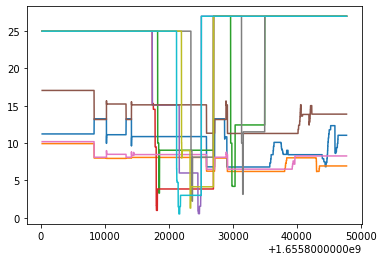

In [6]:
collimator_columns = []
for c in aug.collimators:
    for var in aug.collimator_variables:
        collimator_columns.append(c+var)
        plt.plot(aug.times,aug.all_data[c +var].values)

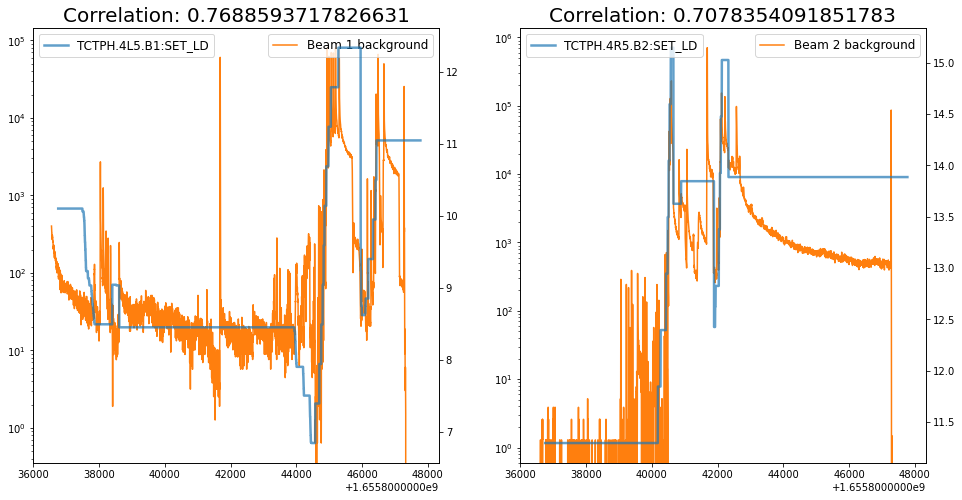

In [7]:
frame,fig = plt.subplots(1,2,figsize = (16,8))

id0 = 25_000

idx = bkg.plusz[id0:].nonzero()[0]
fig[0].plot(
    bkg.times[id0:],
    bkg.plusz[id0:],label = "Beam 1 background",color ="tab:orange")
fig[0].set_yscale("log")
fig[0].legend(loc = "upper right",fontsize = 12)
pearson1 = pearsonr(
    np.log(bkg.plusz[id0:][idx]),
    aug.all_data["TCTPH.4L5.B1:SET_LD"].values[id0:][idx],

)

fig[0].set_title(f"Correlation: {pearson1[0]}",fontsize = 20)


ax0 = fig[0].twinx()
ax0.plot(
    aug.times[id0:],
    aug.all_data["TCTPH.4L5.B1:SET_LD"].values[id0:],
    label ="TCTPH.4L5.B1:SET_LD",
    linewidth = 2.5,alpha = 0.7 )
ax0.legend(loc = "upper left",fontsize = 12)



idx = bkg.minusz[id0:].nonzero()[0]
pearson2 = pearsonr(
    np.log(bkg.minusz[id0:][idx]),
    aug.all_data["TCTPH.4R5.B2:SET_LD"].values[id0:][idx],

)

fig[1].set_title(f"Correlation: {pearson2[0]}",fontsize = 20)





fig[1].plot(bkg.times[id0:],bkg.minusz[id0:],label = "Beam 2 background",color ="tab:orange")
fig[1].set_yscale("log")
fig[1].legend(loc = "upper right",fontsize = 12)

ax1 = fig[1].twinx()
ax1.plot(
    aug.times[id0:],
    aug.all_data["TCTPH.4R5.B2:SET_LD"].values[id0:],
    label ="TCTPH.4R5.B2:SET_LD",
    linewidth = 2.5,alpha = 0.7 )
ax1.legend(loc="upper left",fontsize = 12)
plt.savefig("slide_2.png")

## Preparing data
### Here we calculate the polynomial features. The features and background signals are scaled to zero mean and 1 standard deviation.

### Training data is not sampled from the entire fill rather from the time interval where beam instabilites occured this is seen in large spikes in background.
 Here the raw signal was used (its logarithm), however, convolutions of background could also be implemented. E.g. gaussian convolution to reduce the noise or a convolution with a rising linear function to produce the signal that estimates the background change.


In [8]:
start = 25_000

plus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["plusz"].values[start:],
    names = collimator_columns,
    interaction_only = False
    )
    
plus_preprocessor.make_polynomial()
plus_preprocessor.scale_data()

ptrain_data,ptrain_target = plus_preprocessor.to_torch()

minus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["minusz"].values[start:],
    names = collimator_columns,
    interaction_only= False
    )

minus_preprocessor.make_polynomial()
minus_preprocessor.scale_data()


mtrain_data,mtrain_target = minus_preprocessor.to_torch()


### Polynomial Feature names

In [9]:
for i,name in enumerate(plus_preprocessor.names):
    print(f"{i}: " + name)


0: TCTPH.4L5.B1:SET_LD
1: TCTPV.4L5.B1:SET_LD
2: TCL.4R5.B1:SET_LD
3: TCL.5R5.B1:SET_LD
4: TCL.6R5.B1:SET_LD
5: TCTPH.4R5.B2:SET_LD
6: TCTPV.4R5.B2:SET_LD
7: TCL.4L5.B2:SET_LD
8: TCL.5L5.B2:SET_LD
9: TCL.6L5.B2:SET_LD
10: TCTPH.4L5.B1:SET_LD^2
11: TCTPH.4L5.B1:SET_LD TCTPV.4L5.B1:SET_LD
12: TCTPH.4L5.B1:SET_LD TCL.4R5.B1:SET_LD
13: TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD
14: TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD
15: TCTPH.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD
16: TCTPH.4L5.B1:SET_LD TCTPV.4R5.B2:SET_LD
17: TCTPH.4L5.B1:SET_LD TCL.4L5.B2:SET_LD
18: TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD
19: TCTPH.4L5.B1:SET_LD TCL.6L5.B2:SET_LD
20: TCTPV.4L5.B1:SET_LD^2
21: TCTPV.4L5.B1:SET_LD TCL.4R5.B1:SET_LD
22: TCTPV.4L5.B1:SET_LD TCL.5R5.B1:SET_LD
23: TCTPV.4L5.B1:SET_LD TCL.6R5.B1:SET_LD
24: TCTPV.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD
25: TCTPV.4L5.B1:SET_LD TCTPV.4R5.B2:SET_LD
26: TCTPV.4L5.B1:SET_LD TCL.4L5.B2:SET_LD
27: TCTPV.4L5.B1:SET_LD TCL.5L5.B2:SET_LD
28: TCTPV.4L5.B1:SET_LD TCL.6L5.B2:SET_LD
29: TC

## Creating models and calculating scores

In [10]:
plus_model = model(
    plus_preprocessor.data.shape[1],1
)
print(plus_model.linear.weight.shape)

minus_model = model(
    minus_preprocessor.data.shape[1],1
)

batch_size = 1024
pdataset = dataset(ptrain_data,ptrain_target)
plus_scores = get_scores_mb(
    model = plus_model,
    dataset = pdataset,
   lam = 1,n_runs = 1, n_epochs = 300,batch_size=batch_size
   )

#plus_scores = get_scores(
#        model = plus_model,
#    data = ptrain_data,
#    target=ptrain_target,lam = 1
#    )


mdataset = dataset(mtrain_data,mtrain_target)
minus_scores = get_scores_mb(
    model = minus_model,
    dataset = mdataset,
    lam = 1,n_runs = 1,n_epochs = 300,batch_size=batch_size,
    )


#minus_scores = get_scores(
#    model = minus_model,
#    data = mtrain_data,
#    target=mtrain_target,lam = 1
#   )

torch.Size([1, 65])


100%|██████████| 1/1 [00:12<00:00, 12.58s/it]


### Example of weight norms after training. The result is a sparse model!

(1, 65)
65


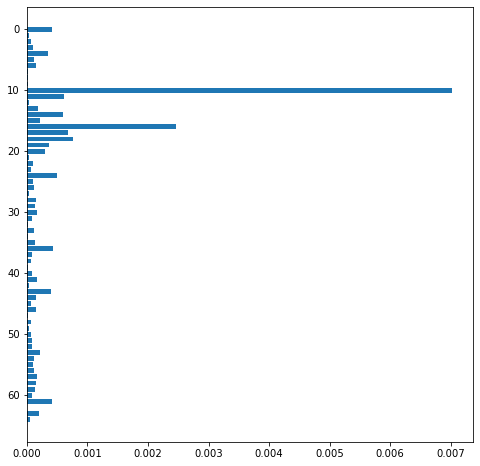

In [44]:
weights = plus_model.linear.weight.detach().numpy()
print(weights.shape)
_,fig = plt.subplots(figsize = (8,8))
fig.barh(
    y = range(weights.flatten().size),
    width = np.fabs(weights.flatten()))
fig.invert_yaxis()
print(weights.flatten().size)


## Getting the most important features for Beam 1.

In [12]:
pfeature_idx = np.argsort(-np.fabs(plus_scores),)
pidx = pfeature_idx
pfeatures = plus_preprocessor.names[pidx]
pwe = weights[:,pidx][0]
pwe = plus_scores[pidx]
pfeature_and_weight = pd.DataFrame(data={"features":pfeatures, "weight":pwe})
psigns = pfeatures[:5]
ppos = pidx[:5]
print("Most important for Beam1 bacgkround")
pfeature_and_weight.head(10)

Most important for Beam1 bacgkround


,features,weight
0,TCTPH.4L5.B1:SET_LD^2,0.913980
1,TCTPH.4L5.B1:SET_LD TCTPV.4R5.B2:SET_LD,0.320454
2,TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD,0.099911
3,TCTPH.4L5.B1:SET_LD TCL.4L5.B2:SET_LD,0.088111
4,TCTPH.4L5.B1:SET_LD TCTPV.4L5.B1:SET_LD,0.079007
5,TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD,0.078436
6,TCTPV.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD,0.063634
7,TCL.4R5.B1:SET_LD TCL.6L5.B2:SET_LD,0.056226
8,TCL.4L5.B2:SET_LD TCL.6L5.B2:SET_LD,0.054926
9,TCTPH.4L5.B1:SET_LD,0.054687


## Getting the most important features for Beam 2.

In [46]:
mfeature_idx = np.argsort(-np.fabs(minus_scores),)
midx = mfeature_idx
mfeatures = plus_preprocessor.names[midx]
mwe = weights[:,midx][0]
mwe = minus_scores[midx]
mfeature_and_weight = pd.DataFrame(data={"features":mfeatures, "weight":mwe})
msigns = mfeatures[:5]
mpos = midx[:5]
print("Most importatn for Beam 2 bacgkround")
mfeature_and_weight.head(3)

Most importatn for Beam 2 bacgkround


,features,weight
0,TCTPV.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD,0.586160
1,TCTPH.4R5.B2:SET_LD^2,0.341356
2,TCL.5R5.B1:SET_LD TCTPH.4R5.B2:SET_LD,0.274231


## Beam1 and Beam2 feature scores

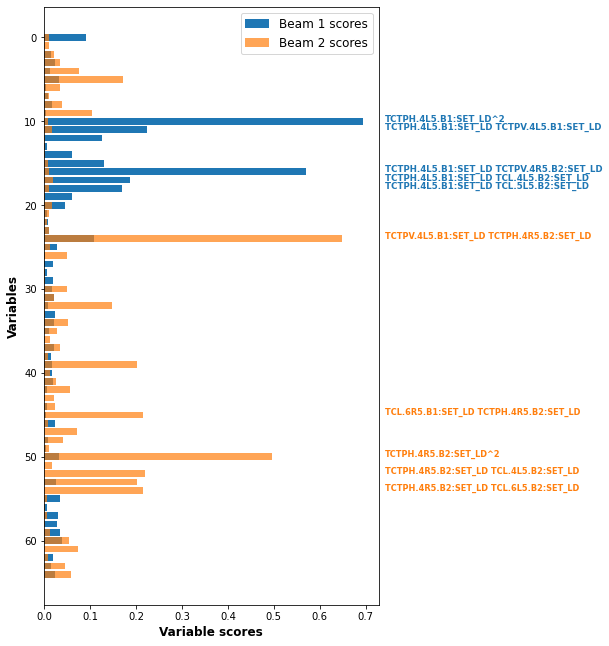

In [14]:

_,fig = plt.subplots(figsize = (6,11))
fig.barh(
    y = range(plus_scores.flatten().size),
    width = np.fabs(plus_scores.flatten()),label = "Beam 1 scores")
xmax = np.maximum(
    np.max(np.fabs(plus_scores.flatten())),
    np.max(np.fabs(minus_scores.flatten()))
    )
for p,s in zip(ppos,psigns):
    fig.text(1.07*xmax,p,s,fontsize = 8.7,color = "tab:blue",fontweight = "bold")


fig.barh(
    y = range(minus_scores.flatten().size),
    width = np.fabs(minus_scores.flatten()),
    label ="Beam 2 scores",alpha = 0.7)

for p,s in zip(mpos,msigns):
    fig.text(1.07*xmax,p,s,fontsize = 8.2,color = "tab:orange",fontweight = "bold")


fig.legend(fontsize = 12)
fig.set_xlabel("Variable scores",fontsize = 12,fontweight = 550)
fig.set_ylabel("Variables",fontsize = 12,fontweight = 550)
fig.invert_yaxis()
plt.savefig("features.png")

## Saving Models

In [50]:
torch.save(plus_model.state_dict(),"plus_model_quadratic.pt")
torch.save(minus_model.state_dict(),"minus_model_quadratic.pt")

## Beam1 model in action.

Correlation with plusz bacgkround
PearsonRResult(statistic=array([0.7886600628953119], dtype=object), pvalue=0.0)


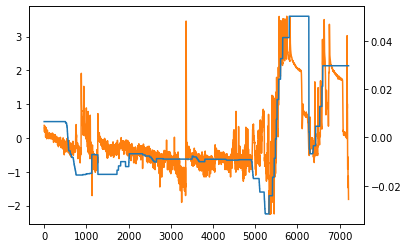

In [16]:
id0 = 25000

plus_model.eval()

print("Correlation with plusz bacgkround")
yplus = plus_model(
        ptrain_data).detach().numpy().flatten()

print(
pearsonr(
        yplus,
        ptrain_target)
        )

plt.plot(ptrain_target,color ="tab:orange",)
plt.twinx()
plt.plot(yplus)


## Beam 2 model in action

Correlation with minusz bacgkround
PearsonRResult(statistic=array([0.8988523594708419], dtype=object), pvalue=0.0)


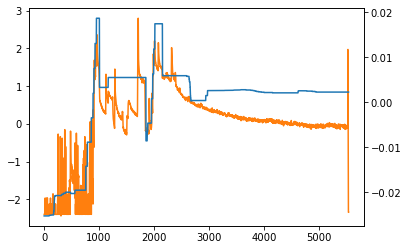

In [17]:
minus_model.eval()

print("Correlation with minusz bacgkround")
yminus = minus_model(
        mtrain_data).detach().numpy().flatten()

print(
pearsonr(
        yminus,
        mtrain_target)
        )

plt.plot(mtrain_target,color ="tab:orange",)
plt.twinx()
plt.plot(yminus)

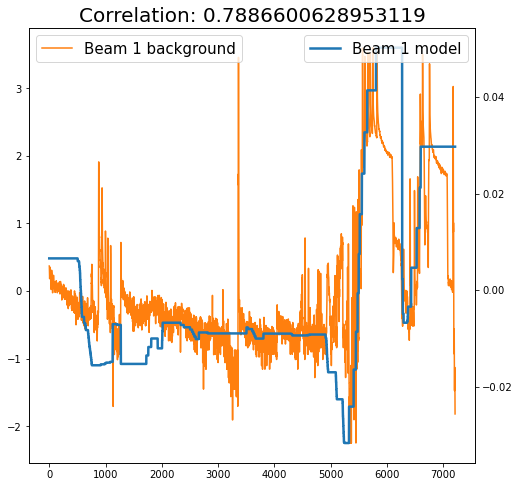

In [18]:
frame,fig = plt.subplots(1,1,figsize = (8,8))

yplus = plus_model(
        ptrain_data).detach().numpy().flatten()

pearson1 = pearsonr(
        yplus,
        ptrain_target)


fig.plot(ptrain_target,color = "tab:orange",label = "Beam 1 background")
ax1 = fig.twinx()
ax1.plot(yplus,color = "tab:blue",linewidth = 2.5,label ="Beam 1 model")
fig.set_title(f"Correlation: {pearson1[0][0]}",fontsize = 20)
fig.legend(loc = "upper left",fontsize =15)
ax1.legend(loc = "upper right",fontsize =15)


plt.savefig("beam1_7825.png")

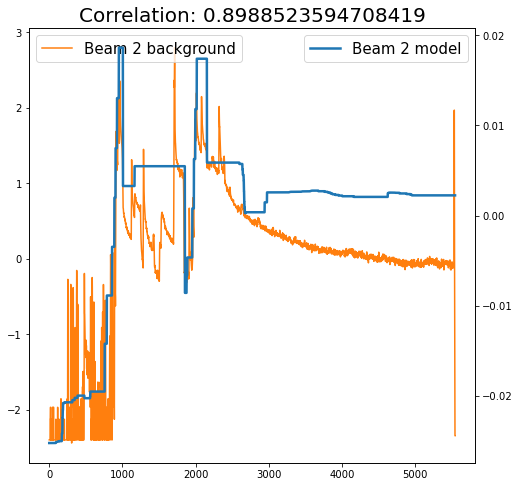

In [19]:
frame,fig = plt.subplots(1,1,figsize = (8,8))

yminus = minus_model(
        mtrain_data).detach().numpy().flatten()

pearson2 = pearsonr(
        yminus,
        mtrain_target)


fig.plot(mtrain_target,color = "tab:orange",label = "Beam 2 background")
ax2 = fig.twinx()
ax2.plot(yminus,color = "tab:blue",linewidth = 2.5,label = "Beam 2 model")
fig.set_title(f"Correlation: {pearson2[0][0]}",fontsize = 20)
fig.legend(loc="upper left",fontsize = 15)
ax2.legend(loc="upper right",fontsize =15)
plt.savefig("beam2_7825.png")



Text(0.5, 1.0, 'Correlation: 0.8678846168570444')

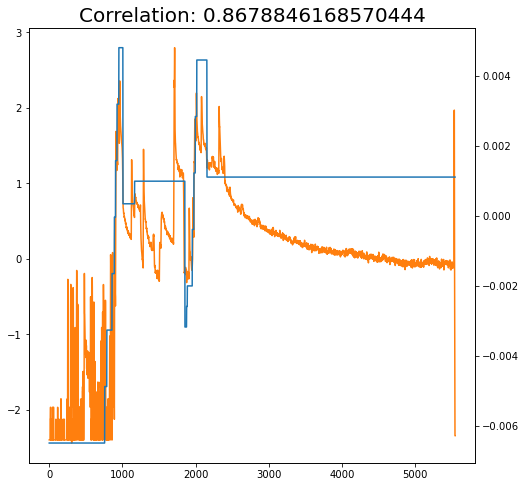

In [49]:
variables = [
    "TCTPV.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD",
    "TCTPH.4R5.B2:SET_LD^2",
    "TCTPH.4R5.B2:SET_LD TCL.4L5.B2:SET_LD"]

minus_preprocessor.names
vars, index = minus_preprocessor.select_variables(variables = variables)
weights = minus_model.linear.weight[:,index].detach().numpy()
signal = 0
weights[0]
for v,w in zip(vars,weights[0]):
    signal = v*w

frame,fig = plt.subplots(figsize = (8,8))
fig.plot(minus_preprocessor.target,color = "tab:orange")

corr = pearsonr(
        signal,
        minus_preprocessor.target)

tw = fig.twinx()
tw.plot(signal)
fig.set_title(f"Correlation: {corr[0][0]}",fontsize = 20)

## Correlation with only the most important features of beam1 and beam1 background
By observing only the features with highest scores we can get a correlation $> 0.7$
<br>
Valudation of these results is performed on different fills!

PearsonRResult(statistic=0.768859371782663, pvalue=0.0)


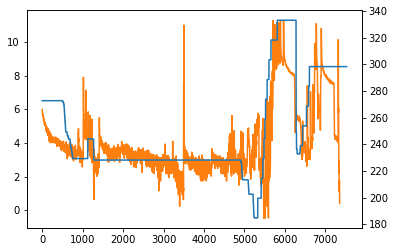

In [72]:
id = bkg.plusz[id0:].nonzero()[0]
x1 = aug.all_data["TCTPH.4L5.B1:SET_LD"].values[id0:]
x2 = aug.all_data["TCL.5L5.B2:SET_LD" ].values[id0:]
plt.plot(np.log(bkg.plusz[id0:][id]),color = "tab:orange")
plt.twinx()
plt.plot(x1*x2)

print(
    pearsonr(
        x1[id]*x2[id],
        np.log(
            bkg.plusz[id0:][id]
        )
    )
)



## Correlation with only the most important features of beam2 and beam2 background

PearsonRResult(statistic=0.7078354091851781, pvalue=0.0)


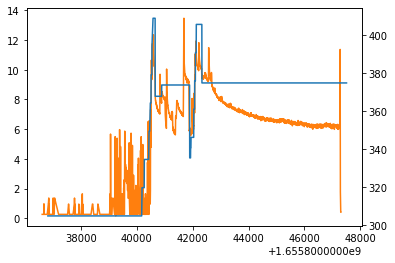

In [44]:
id0 = 25000
id = bkg.minusz[id0:].nonzero()[0]
x1 = aug.all_data["TCTPH.4R5.B2:SET_LD"].values[id0:]
x2 = aug.all_data["TCL.6R5.B1:SET_LD" ].values[id0:]
plt.plot(bkg.times[id0:][id],np.log(bkg.minusz[id0:][id]),color = "tab:orange")
plt.twinx()
plt.plot(aug.times[id0:][id],x1[id]*x2[id])

print(
    pearsonr( 
        x1[id]*x2[id],
        np.log(
            bkg.minusz[id0:][id]
        )
    )
)

### Simple linear model

In [ ]:
plus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["plusz"].values[start:],
    names = collimator_columns
    )
plus_preprocessor.scale_data()


minus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["minusz"].values[start:],
    names = collimator_columns
    )

minus_preprocessor.scale_data()


ptrain_data,ptrain_target = plus_preprocessor.to_torch()
mtrain_data,mtrain_target = minus_preprocessor.to_torch()


In [ ]:
plus_model = model(
    plus_preprocessor.data.shape[1],1
)
print(plus_model.linear.weight.shape)

minus_model = model(
    minus_preprocessor.data.shape[1],1
)

plus_scores = get_scores(
    model = plus_model,
    data = ptrain_data,
    target=ptrain_target,
    )


minus_scores = get_scores(
    model = minus_model,
    data = mtrain_data,
    target=mtrain_target,
    )

torch.save(plus_model.state_dict(),"plus_model_linear.pt")
torch.save(minus_model.state_dict(),"minus_model_linear.pt")

torch.Size([1, 10])


 63%|██████▎   | 126/200 [00:28<00:16,  4.44it/s]


KeyboardInterrupt: 

### Linear model in action: Beam 1

Correlation with plusz bacgkround
PearsonRResult(statistic=array([0.37385715340266906], dtype=object), pvalue=0.0)


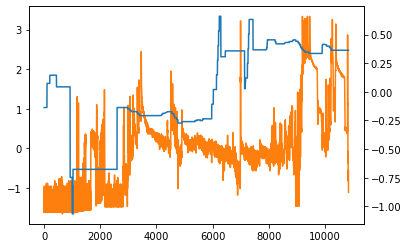

In [ ]:
plus_model.eval()

print("Correlation with plusz bacgkround")
yplus = plus_model(
        ptrain_data).detach().numpy().flatten()

print(
pearsonr(
        yplus,
        ptrain_target)
        )

plt.plot(ptrain_target,color ="tab:orange",)
plt.twinx()
plt.plot(yplus)


### Linear model in action: Beam 2

Correlation with plusz bacgkround
PearsonRResult(statistic=array([0.4635520881779746], dtype=object), pvalue=0.0)


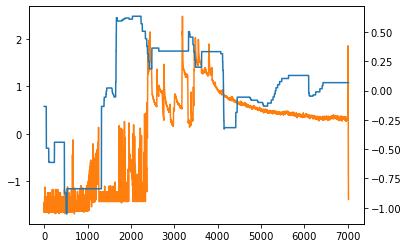

In [ ]:
minus_model.eval()

print("Correlation with plusz bacgkround")
yminus = minus_model(
        mtrain_data).detach().numpy().flatten()

print(
pearsonr(
        yminus,
        mtrain_target)
        )

plt.plot(mtrain_target,color ="tab:orange",)
plt.twinx()
plt.plot(yminus)


### Cubic model

In [ ]:
start = 20_000

plus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["plusz"].values[start:],
    names = collimator_columns,
    deg = 3
    )
    
plus_preprocessor.make_polynomial()
plus_preprocessor.scale_data()

ptrain_data,ptrain_target = plus_preprocessor.to_torch()

minus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["minusz"].values[start:],
    names = collimator_columns,
    deg = 3
    )

minus_preprocessor.make_polynomial()
minus_preprocessor.scale_data()

mtrain_data,mtrain_target = minus_preprocessor.to_torch()


In [ ]:
plus_model = model(
    plus_preprocessor.data.shape[1],1
)
print(plus_model.linear.weight.shape)

minus_model = model(
    minus_preprocessor.data.shape[1],1
)

plus_scores = get_scores(
    model = plus_model,
    data = ptrain_data,
    target=ptrain_target,
    )


minus_scores = get_scores(
    model = minus_model,
    data = mtrain_data,
    target=mtrain_target,
    )


torch.Size([1, 175])


100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


In [ ]:
torch.save(plus_model.state_dict(),"plus_model_cubic.pt")
torch.save(minus_model.state_dict(),"minus_model_cubic.pt")

In [ ]:
weights = plus_model.linear.weight.detach().numpy()

pfeature_idx = np.argsort(-np.fabs(plus_scores),)
pidx = pfeature_idx
pfeatures  = plus_preprocessor.names[pidx]
pwe = weights[:,pidx][0]
pwe = plus_scores[pidx]
pfeature_and_weight = pd.DataFrame(data={"features":pfeatures, "weight":pwe})
psigns = pfeatures[:8]
ppos = pidx[:8]
print("Most important for Beam1 bacgkround")
pfeature_and_weight.head(10)

Most important for Beam1 bacgkround


,features,weight
0,TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD TCL.6L5....,158.751078
1,TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD,149.929829
2,TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCL.6L5....,149.697415
3,TCTPH.4L5.B1:SET_LD TCL.6L5.B2:SET_LD,146.784530
4,TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCL.5L5....,137.517661
5,TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD TCL.5L5....,135.888408
6,TCTPH.4L5.B1:SET_LD,135.833600
7,TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD TCL.6L5....,132.908378
8,TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD,131.366727
9,TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCL.6R5....,128.645163


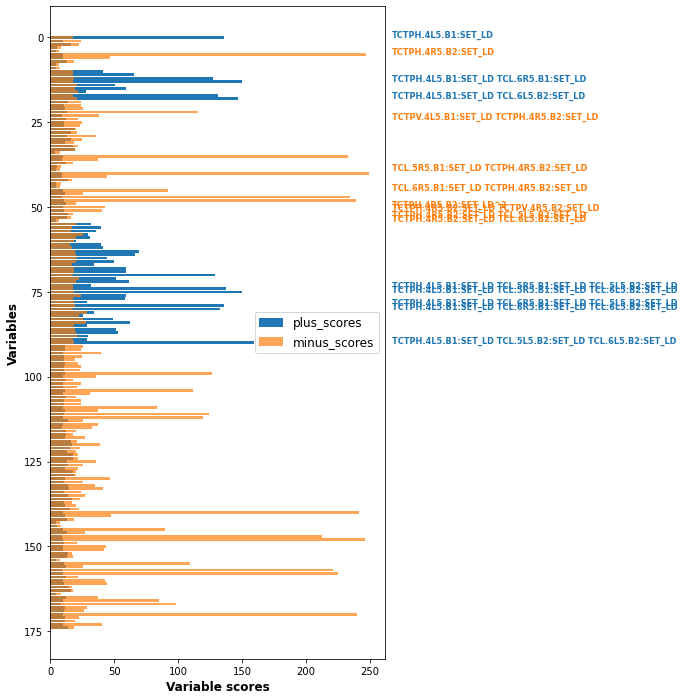

In [ ]:

_,fig = plt.subplots(figsize = (6,12))
fig.barh(
    y = range(plus_scores.flatten().size),
    width = np.fabs(plus_scores.flatten()),label = "plus_scores")
xmax = np.maximum(
    np.max(np.fabs(plus_scores.flatten())),
    np.max(np.fabs(minus_scores.flatten())))
for p,s in zip(ppos,psigns):
    fig.text(1.07*xmax,p,s,fontsize = 8.2,color = "tab:blue",fontweight = "bold")


fig.barh(
    y = range(minus_scores.flatten().size),
    width = np.fabs(minus_scores.flatten()),
    label ="minus_scores",alpha = 0.7)

for p,s in zip(mpos,msigns):
    fig.text(1.07*xmax,p,s,fontsize = 8.2,color = "tab:orange",fontweight = "bold")


fig.legend(fontsize = 12)
fig.set_xlabel("Variable scores",fontsize = 12,fontweight = 550)
fig.set_ylabel("Variables",fontsize = 12,fontweight = 550)
fig.invert_yaxis()

Correlation with plusz bacgkround
PearsonRResult(statistic=array([0.8279923463895816], dtype=object), pvalue=0.0)


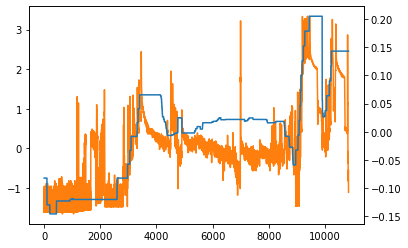

In [ ]:
plus_model.eval()

print("Correlation with plusz bacgkround")
yplus = plus_model(
        ptrain_data).detach().numpy().flatten()

print(
pearsonr(
        yplus,
        ptrain_target)
        )

plt.plot(ptrain_target,color ="tab:orange",)
plt.twinx()
plt.plot(yplus)


Correlation with plusz bacgkround
PearsonRResult(statistic=array([0.9439117960570941], dtype=object), pvalue=0.0)


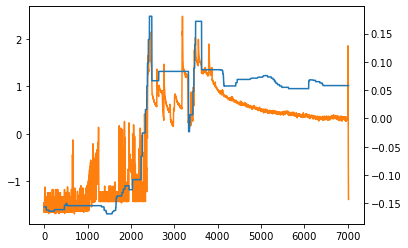

In [ ]:
minus_model.eval()

print("Correlation with plusz bacgkround")
yminus = minus_model(
        mtrain_data).detach().numpy().flatten()

print(
pearsonr(
        yminus,
        mtrain_target)
        )

plt.plot(mtrain_target,color ="tab:orange",)
plt.twinx()
plt.plot(yminus)


In [ ]:
for f in pfeature_and_weight["features"].values:
    print(f)

TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD TCL.6L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCL.6L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.6L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCL.5L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD TCL.5L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD TCL.6L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCL.6R5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCL.4R5.B1:SET_LD TCL.5R5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCL.4R5.B1:SET_LD TCL.6R5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCL.4R5.B1:SET_LD
TCTPH.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD TCL.6L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.5R5.B1:SET_LD TCTPV.4R5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.6R5.B1:SET_LD TCTPH.4R5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCTPV.4R5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.4R5.B1:SET_LD TCL.5L5.B2:SET_LD
TCTPH.4L5.B1:SET_LD TCL.4R5.B1:SET_LD TCL.6L5.B2:SET_LD
TCTPH.4L5.B1:SET

### Cubic model may have too many free parameters, and therefore shows signs of overfitting.
This is visible from the fact that the model itself correlates witht he background very well, yet the most important features of the model do not show a similar correlation on their own.

Correlation with cubic top feature
PearsonRResult(statistic=0.768859371782663, pvalue=0.0)


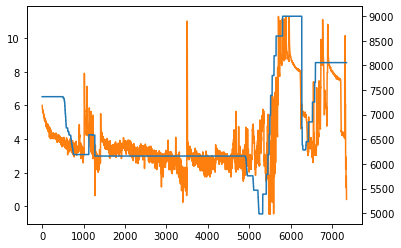

In [ ]:
id0 = 25000
id = bkg.plusz[id0:].nonzero()[0]
x1 = aug.all_data["TCTPH.4L5.B1:SET_LD"].values[id0:]
x2 = aug.all_data["TCL.5R5.B1:SET_LD" ].values[id0:]
x3 =  aug.all_data["TCL.6R5.B1:SET_LD" ].values[id0:]


print("Correlation with cubic top feature")
print(
    pearsonr(
        np.log(bkg.plusz[id0:][id]),
        x1[id]*x2[id]*x3[id]
    )
)

plt.plot(np.log(bkg.plusz[id0:][id]),color = "tab:orange")
plt.twinx()
plt.plot(
    x1[id]*x2[id]*x3[id],color = "tab:blue"
)

In [ ]:
for f in mfeature_and_weight["features"].values:
    print(f)

TCTPH.4R5.B2:SET_LD
TCTPH.4R5.B2:SET_LD^2
TCTPH.4R5.B2:SET_LD TCL.6L5.B2:SET_LD
TCL.6R5.B1:SET_LD TCTPH.4R5.B2:SET_LD
TCL.5R5.B1:SET_LD TCTPH.4R5.B2:SET_LD
TCTPH.4R5.B2:SET_LD TCL.5L5.B2:SET_LD
TCTPV.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD
TCTPH.4R5.B2:SET_LD TCTPV.4R5.B2:SET_LD
TCTPV.4R5.B2:SET_LD^2
TCL.6R5.B1:SET_LD TCTPV.4R5.B2:SET_LD
TCTPV.4R5.B2:SET_LD
TCTPV.4R5.B2:SET_LD TCL.6L5.B2:SET_LD
TCTPV.4R5.B2:SET_LD TCL.5L5.B2:SET_LD
TCL.5R5.B1:SET_LD TCTPV.4R5.B2:SET_LD
TCL.4R5.B1:SET_LD TCTPH.4R5.B2:SET_LD
TCTPV.4L5.B1:SET_LD TCTPV.4R5.B2:SET_LD
TCTPH.4R5.B2:SET_LD TCL.4L5.B2:SET_LD
TCL.4R5.B1:SET_LD TCL.6L5.B2:SET_LD
TCL.4R5.B1:SET_LD TCTPV.4R5.B2:SET_LD
TCTPV.4R5.B2:SET_LD TCL.4L5.B2:SET_LD
TCTPV.4L5.B1:SET_LD TCL.6R5.B1:SET_LD
TCTPV.4L5.B1:SET_LD^2
TCTPH.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD
TCTPV.4L5.B1:SET_LD TCL.6L5.B2:SET_LD
TCTPV.4L5.B1:SET_LD TCL.5L5.B2:SET_LD
TCTPV.4L5.B1:SET_LD TCL.4R5.B1:SET_LD
TCL.4R5.B1:SET_LD TCL.5R5.B1:SET_LD
TCTPV.4L5.B1:SET_LD
TCL.4R5.B1:SET_LD TCL.5L5.B2:SET_L